In [23]:
%pylab inline
from cvxopt import solvers
from cvxopt import matrix
from cvxopt import spdiag

from sklearn import svm
from sklearn.datasets import make_classification

random_state = 1

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


1. Квадратичное программирование и QP-солвер
==========================

Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:

$$f(x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, $$
$$ \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; $$
$$ 0 \leq x_1 \leq 3, \; x_2 \geq 0$$

In [24]:

#?solvers.qp

In [25]:

P = 2*matrix([[1.0, 0.0], [0.0, 4.0]])
q = matrix([-8.0, -16.0])
G = matrix([[1.0, 1.0, -1.0, 0.0], [1.0, 0.0, 0.0, -1.0]])
h = matrix([5.0, 3.0, 0.0, 0.0])

A = G + 0.005
b = h + 0.005
print q
print matrix([G, G])
#sol = solvers.qp(P, q, G, h)

#print sol['x']

[-8.00e+00]
[-1.60e+01]

[ 1.00e+00  1.00e+00]
[ 1.00e+00  0.00e+00]
[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[ 1.00e+00  1.00e+00]
[ 1.00e+00  0.00e+00]
[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]



Какие из ограничений-неравенств задачи являются активными, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?
=====================

Оптимальное решение $ x^* = (x_1, x_2) = (3.0, 2.0)$

Активные ограничения 
$$
x_1 + x_2 \leq 5 \\
x_1 \leq 3
$$

Выбросив ограничения неотрицательности получим тот же ответ.

In [26]:
P = 2*matrix([[1.0, 0.0], [0.0, 4.0]])
q = matrix([-8.0, -16.0])
G = matrix([[1.0, 1.0], [1.0, 0.0]])
h = matrix([5.0, 3.0])

sol = solvers.qp(P, q, G, h)

print sol['x']

[ 3.00e+00]
[ 2.00e+00]



2. Линейный SVM
================

Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.

\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}

In [27]:
'''
LinearSVM solved with QP solver from CVXOPT
'''
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        import copy
        trainSet = X
        
        if self.transform != None :
            trainSet = self.transform(copy.deepcopy(trainSet))
            
        
        size, n_features = trainSet.shape
        self.weights_ = empty(n_features)
        self.bias_ = 0
        # x -> (weights, epsilons, b)
        x_size = n_features + size + 1
        y = y * 2 - 1
        # целевая функция
        P = spdiag([1] * n_features + [0] * (size + 1))
        q = matrix([0.0] * n_features + [self.C] * size + [0.0], 
                   (n_features + size + 1, 1))
        # ограничения не равенства
        # G*x <= h
        G = matrix([
                [matrix([0] * n_features * size, (size, n_features))], 
                    [spdiag([-1.0] * size)],
                    [matrix([0] * size, (size, 1))]
                   ])
        h = matrix([0.0] * size, (size, 1))
        
        A = copy.deepcopy(trainSet)
        for i in range(size):
            for j in range(n_features):
                A[i][j] *= y[i]

        am = matrix(A)
        ym = matrix(y * 1.0)

        A = matrix([[am], [spdiag([1] * size)], [ym]])
        b = matrix([1.0] * size, (size, 1))   
 
        G = matrix([G, -A])
        h = matrix([h, -b])
        solvers.options['show_progress']=False
        sol = solvers.qp(P, q, G, h)
        
        self.weights_ = sol['x'][:n_features]
        self.bias_ = sol['x'][-1]
        
    def predict_proba(self, X):
        import copy
        trainSet = X
        
        if self.transform != None :
            trainSet = self.transform(copy.deepcopy(trainSet))
            
        return (dot(trainSet, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):          
        return sign(self.predict_proba(X))
    

Сгенерируйте три случайные двумерные выборки для бинарной классификации:
- с линейно-разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам

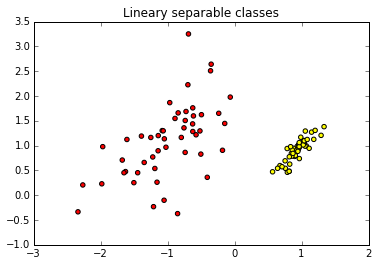

In [28]:
X, y = make_classification(n_samples=100, 
                           n_features=2, 
                           n_redundant=0, 
                           n_clusters_per_class=1, 
                           random_state=random_state)

scatter(X[:,0], X[:, 1], c=y, cmap='autumn')
title('Lineary separable classes')

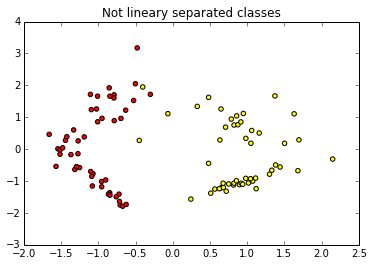

In [29]:
X, y = make_classification(n_samples=100, 
                           n_features=2, 
                           n_redundant=0, 
                           n_clusters_per_class=2, 
                           random_state=random_state)

scatter(X[:,0], X[:, 1], c=y, cmap='autumn')
title('Not lineary separated classes')

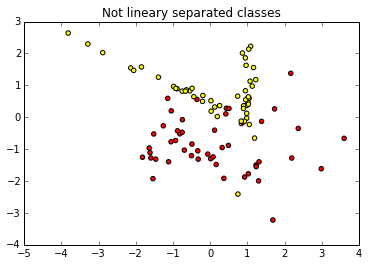

In [30]:
X, y = make_classification(n_samples=100, 
                           n_features=2, 
                           n_redundant=0, 
                           n_clusters_per_class=2, 
                           random_state=random_state*2)

scatter(X[:,0], X[:, 1], c=y, cmap='autumn')
title('Not lineary separated classes')

Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор f(x)=±1. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра C.

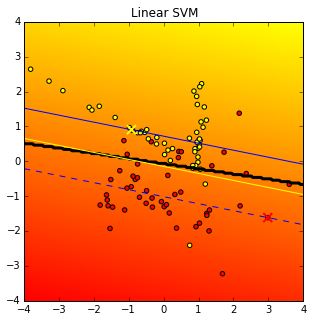

In [31]:
model = LinearSVM(C=0.1)
model.fit(X, y)

lib_model = svm.LinearSVC()
lib_model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)


zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()]), xx.shape)
lib_zz = np.reshape(lib_model.predict(c_[xx.ravel(), yy.ravel()]), xx.shape)
# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0
contour(xx, yy, lib_zz, levels=(0,), colors='black', linewidths=3, zorder=1)
contour(xx, yy, zz, levels=(0,), colors='yellow', linewidths=1, zorder=1)

# Опорные вектора
contour(xx, yy, zz, levels=(1, -1), colors='blue', linewidths=1, zorder=1)

# Опорные элементы
y_pred_prob = model.predict_proba(X)
error = 0.001
err = abs(abs(y_pred_prob) - 1) < error

scatter(X[err, 0], X[err, 1], c=y[err], marker='x', cmap='autumn', s=80, linewidths=2)

xlim([-4, 4])
ylim([-4, 4])
_ = title('Linear SVM')
   

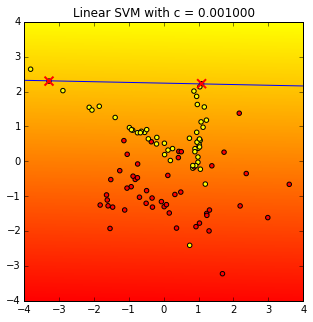

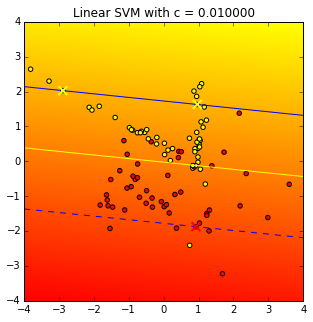

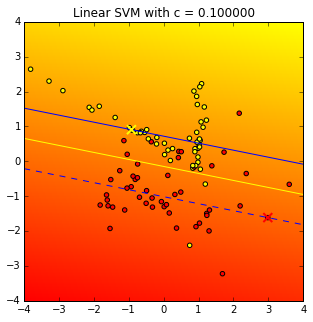

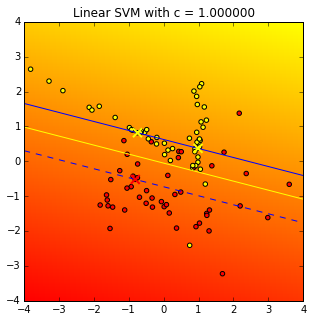

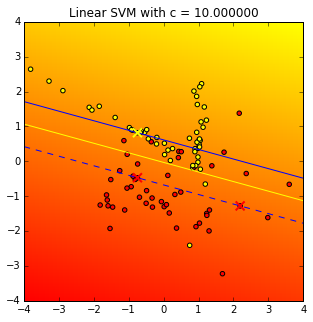

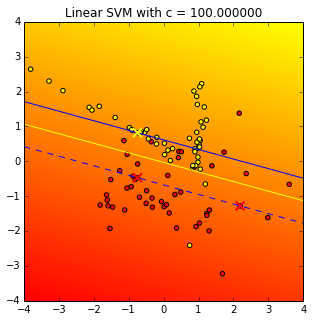

In [32]:
for c in [ 10 ** x for x in range(-3, 3, 1)]:
    model = LinearSVM(C=c)
    model.fit(X, y)
    
    figure(figsize=(5, 5))
    scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

    xvals = linspace(-4, 4, 200)
    yvals = linspace(-4, 4, 200)
    
    xx, yy = np.meshgrid(xvals, yvals)

    zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()]), xx.shape)
    pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
    
    contour(xx, yy, zz, levels=(0,), colors='yellow', linewidths=1, zorder=1)
    # Опорные элементы
    contour(xx, yy, zz, levels=(1, -1), colors='blue', linewidths=1, zorder=1)
    
    y_pred_prob = model.predict_proba(X)
    error = 0.001
    err = abs(abs(y_pred_prob) - 1) < error

    scatter(X[err, 0], X[err, 1], c=y[err], marker='x', cmap='autumn', s=80, linewidths=2)

    xlim([-4, 4])
    ylim([-4, 4])
    _ = title('Linear SVM with c = %f' % c)

Как зависит число опорных векторов от параметра C для различных выборок?

В общем случае число опорных векторов может быть от 1 до всех элементов выборки.
Чем больше С тем меньше разрешается нарушителей (т.е. векторов, которые классифицируем неправильно)

Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

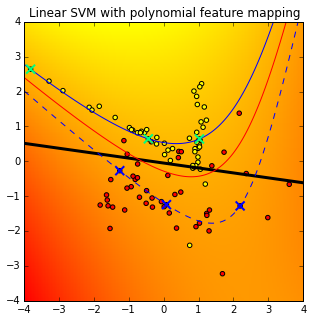

In [33]:
def map_object_to_poly(x):
    res = np.array(x)
    new_features = []
    for i in range(len(x)):
        for j in range(i + 1):
            new_features += [res[i] * res[j]]
            
    return np.append(res, new_features)
    


def map_set_to_poly(X):
    poly = np.array(X)
    res = []
    for row in poly:
        res += [map_object_to_poly(row)]

    return np.array(res)


model = LinearSVM(C=0.1, transform=map_set_to_poly)
model.fit(X, y)

lib_model = svm.LinearSVC(C=0.1)
lib_model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)


zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()]), xx.shape)
lib_zz = np.reshape(lib_model.decision_function(c_[xx.ravel(), yy.ravel()]), xx.shape)
# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, lib_zz, levels=(0,), colors='black', linewidths=3, zorder=1)
contour(xx, yy, zz, levels=(0,), colors='red', linewidths=1, zorder=1)

# Опорные вектора
contour(xx, yy, zz, levels=(1, -1), colors='blue', linewidths=1, zorder=1)
#contour(xx, yy, lib_zz, levels=(1, -1), colors='black', linewidths=3, zorder=1)

# Опорные элементы
y_pred_prob = model.predict_proba(X)
error = 0.00001
err = abs(abs(y_pred_prob) - 1) < error

scatter(X[err, 0], X[err, 1], c=y[err], marker='x', cmap='winter', s=80, linewidths=2)

xlim([-4, 4])
ylim([-4, 4])
_ = title('Linear SVM with polynomial feature mapping')


3. Двойственный переход и Ядровой SVM
==================================

Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.

In [34]:
'''
KernelSVM dual problem solved with QP solver from CVXOPT
'''
from sklearn.base import BaseEstimator

class KernelSVM(BaseEstimator):

    def __poly_kernel(self, x1, x2):
        return (np.dot(x1, x2) + 1) ** self.degree

    def __linear_kernel(self, x1, x2):
        return np.dot(x1, x2)
    
    def __rbf_kernel(self, x1, x2):
        return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * self.sigma))
    
    
    def __init__(self, C, transform=None, kernel='poly', degree=3, sigma=1.0):
        self.C = C
        self.transform = transform
        
        kernels = {
            'linear' : self.__linear_kernel,
            'rbf'    : self.__rbf_kernel,
            'poly'   : self.__poly_kernel
        }
        
        self.kernel = kernels[kernel]
        self.degree = degree
        self.sigma = sigma
        
        self.lmbdas = []
        self.svX = []
        self.svy = []
        
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        import copy
        trainSet = X
        
        if self.transform != None :
            trainSet = self.transform(copy.deepcopy(trainSet))
            
        size, n_features = trainSet.shape
        self.weights_ = empty(n_features)
        self.bias_ = 0
        
        # x -> (lambdas)
        y = y * 2 - 1
        # целевая функция
        
        K = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                K[i, j] = self.kernel(trainSet[i], trainSet[j])
                
                
        P = spdiag(list(y)) * matrix(K) * spdiag(list(y))
        q = -matrix([1.0] * size, (size, 1))
 
        # ограничения не равенства
        # G*x <= h
        G = matrix([ spdiag([-1.0] * size), spdiag([1.0] * size)], tc='d')
        h = matrix([ [0.0] * size + [self.C] * size ], (2*size, 1))
        
        A = matrix(y, (1, size), tc='d')
        b = matrix([0.0])
 
        solvers.options['show_progress']=False
        sol = solvers.qp(P, q, G, h, A=A, b=b)
        
        # recover primary problem solution
        lambdas = np.ravel(sol['x'])
        
        error = 0.000001        
        sv_idxs = np.where(abs(np.array(sol['x'])) > error)[0]
        
        self.lmbdas = lambdas[sv_idxs]
        self.svX = X[sv_idxs]
        self.svy = y[sv_idxs]
        
        #bias
        self.bias_ = 0
        
        for i in range(len(self.lmbdas)):
            self.bias_ += self.svy[i] - np.sum(self.lmbdas * self.svy * K[sv_idxs[i], sv_idxs])
        self.bias_ /= len(self.lmbdas)
         
    def predict_proba(self, X):
        import copy
        trainSet = X
        
        if self.transform != None :
            trainSet = self.transform(copy.deepcopy(trainSet))
        
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            res = 0
            for lmbda, svy, svX in zip(self.lmbdas, self.svy, self.svX):
                res += lmbda * svy * self.kernel(svX, X[i])
            y_predict[i] = res
            
        return y_predict + self.bias_
        
        
            
    def predict(self, X):
        return sign(self.predict_proba(X))
    

Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(x)=±1$. Выделите опорные вектора точками другой формы или большего размера.

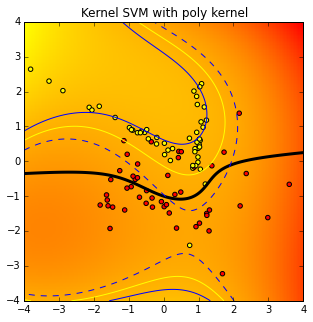

In [35]:
model = KernelSVM(C=0.1, kernel='poly', degree=3, sigma=1)
model.fit(X, y)

lib_model = svm.SVC(C=0.1, kernel='poly', degree=3, gamma=1)
lib_model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

minval = -4
maxval = -minval

xvals = linspace(minval, maxval, 200)
yvals = linspace(minval, maxval, 200)

xx, yy = np.meshgrid(xvals, yvals)


zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()]), xx.shape)
lib_zz = np.reshape(lib_model.decision_function(c_[xx.ravel(), yy.ravel()]), xx.shape)
# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, lib_zz, levels=(0,), colors='black', linewidths=3, zorder=1)
contour(xx, yy, zz, levels=(0,), colors='yellow', linewidths=1, zorder=1)

# Опорные вектора
contour(xx, yy, zz, levels=(1, -1), colors='blue', linewidths=1, zorder=1)
#contour(xx, yy, lib_zz, levels=(1, -1), colors='black', linewidths=3, zorder=1)

# Опорные элементы
y_pred_prob = model.predict_proba(X).flatten()
error = 0.001
err = abs(abs(y_pred_prob) - 1) < error

scatter(X[err, 0], X[err, 1], c=y[err], marker='x', cmap='autumn', s=80, linewidths=2)

xlim([minval, maxval])
ylim([minval, maxval])
_ = title('Kernel SVM with poly kernel')

Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$

Чем больше $C$, тем меньше разрешается векторов-нарушителей и разделяющий слой (уровни [-1, 1]) тоньше. 
Чем больше $d$, тем лучше разделяющая поверхность подстраивается под выборку, большие значения $d$ могут привести к переобучению

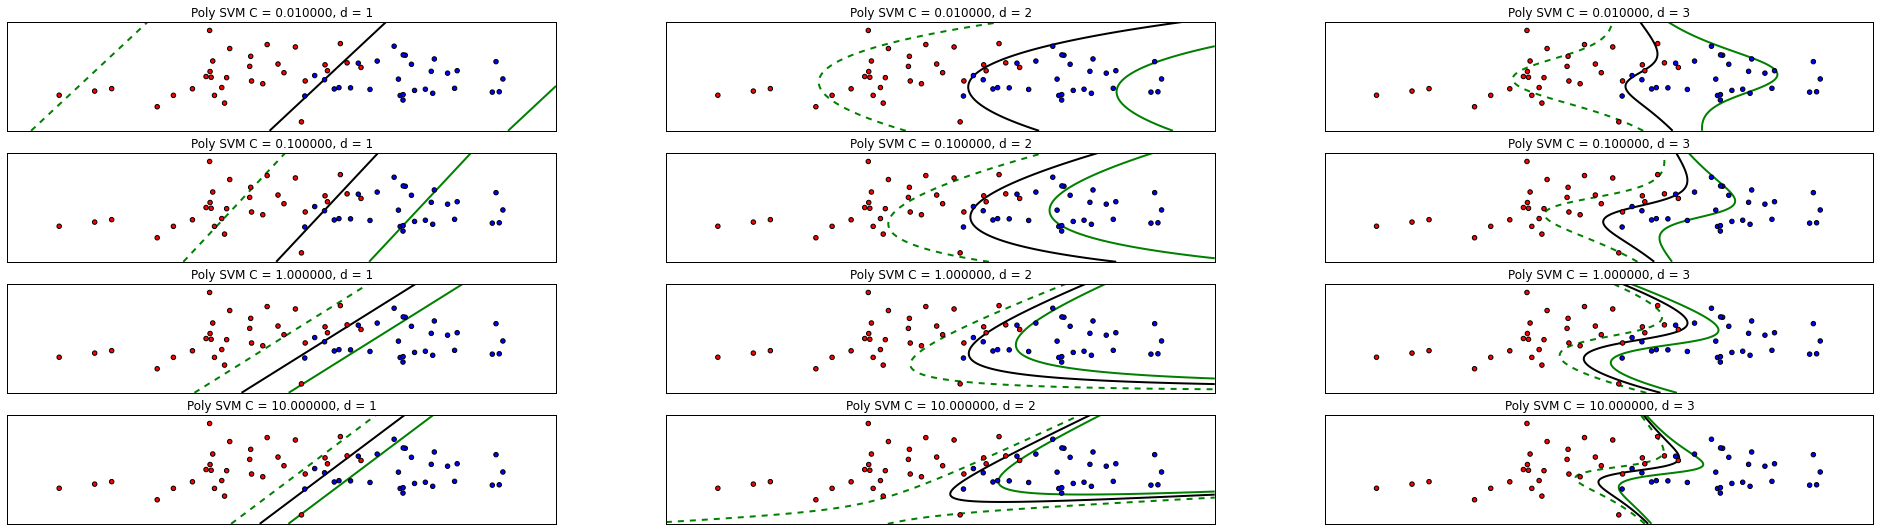

CPU times: user 52.2 s, sys: 24 ms, total: 52.2 s
Wall time: 52.5 s


In [36]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification


h = .02  # step size in the mesh

     

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [#make_moons(noise=0.3, random_state=0),
            #make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    # iterate over classifiers
    C_range = [10 ** p for p in range(-2, 2)]
    d_range = range(1, 4)
    for C in C_range:
        for d in d_range:
            name = 'Poly SVM C = %f, d = %d' % (C, d)
            clf = KernelSVM(C=C, kernel='poly', degree=d)
    
            ax = plt.subplot(len(C_range), len(d_range), i)
            clf.fit(X_train, y_train)
            #score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, m_max]x[y_min, y_max].
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            #ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
            # Цветной фон, соответствующий значению решающего правила
            #ax.pcolormesh(xx, yy, Z, cmap=cm_bright, zorder=0)

            # Линия уровня, соответствующая значению 0
            ax.contour(xx, yy, Z, levels=(0,), colors='black', linewidths=2, zorder=1)

            # Опорные уровни
            ax.contour(xx, yy, Z, levels=(1, -1), colors='green', linewidths=2, zorder=1)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_title(name)
            i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $σ$? Поварьируйте параметры $C$ и $σ$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

Малые значения $σ$ ведут к переобучению

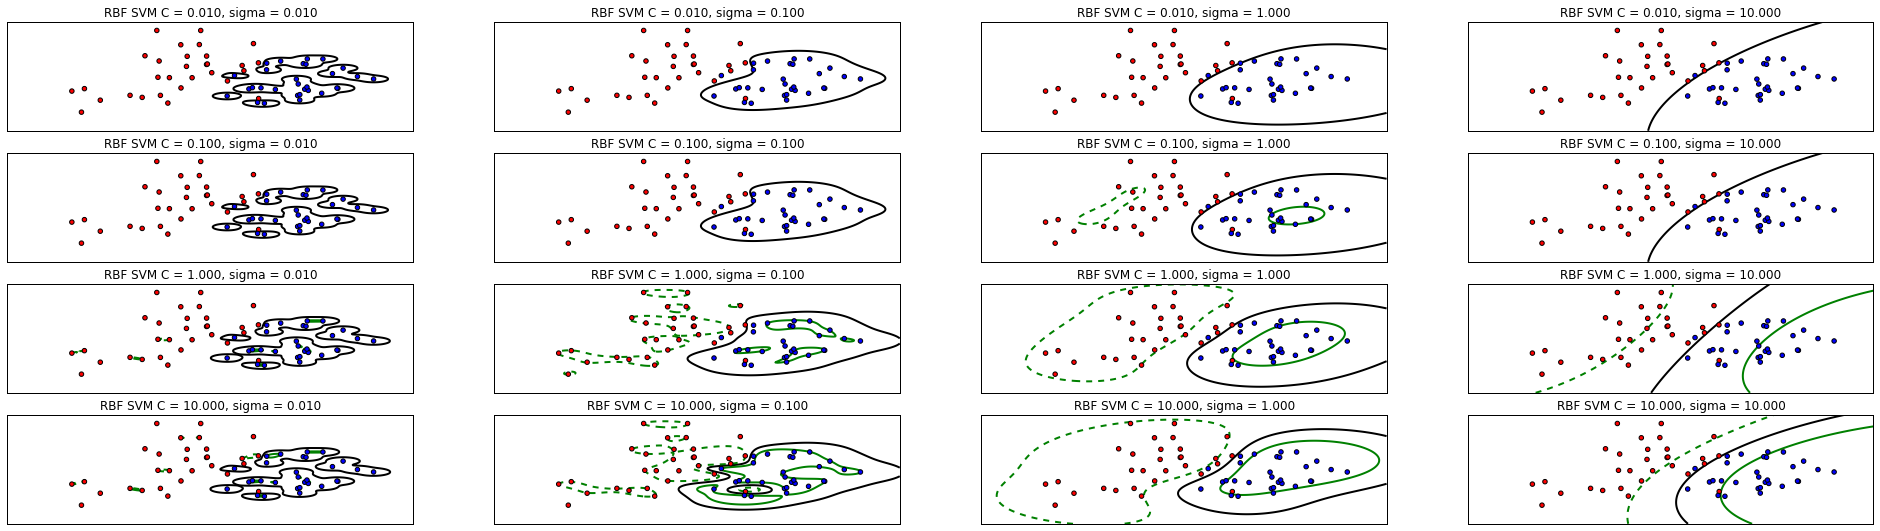

CPU times: user 7min 11s, sys: 44 ms, total: 7min 11s
Wall time: 7min 12s
Parser   : 144 ms


In [37]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification


h = .02  # step size in the mesh

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [#make_moons(noise=0.3, random_state=0),
            #make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    # iterate over classifiers
    C_range = [10 ** p for p in range(-2, 2)]
    sigma_range = [10 ** p for p in range(-2, 2)]
    for C in C_range:
        for sigma in sigma_range:
            name = 'RBF SVM C = %.3f, sigma = %.3f' % (C, sigma)
            clf = KernelSVM(C=C, kernel='rbf', sigma=sigma)
    
            ax = plt.subplot(len(C_range), len(sigma_range), i)
            clf.fit(X_train, y_train)
            #score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, m_max]x[y_min, y_max].
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            #ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
            # Цветной фон, соответствующий значению решающего правила
            #ax.pcolormesh(xx, yy, Z, cmap=cm_bright, zorder=0)

            # Линия уровня, соответствующая значению 0
            ax.contour(xx, yy, Z, levels=(0,), colors='black', linewidths=2, zorder=1)

            # Опорные уровни
            ax.contour(xx, yy, Z, levels=(1, -1), colors='green', linewidths=2, zorder=1)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
            # and testing points
            #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
            #           alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_title(name)
            #ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            #       size=15, horizontalalignment='right')
            i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()